In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
sns.set() # use seaborn plotting style

## Multinomial Naive Bayes Classifier

Referenced model from: 
1. https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a

In [30]:
train_data = pd.read_csv('final_data/train.csv')
valid_data = pd.read_csv('final_data/valid.csv')
test_data = pd.read_csv('final_data/test.csv')

In [31]:
# remove rows with missing values
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data = test_data.dropna()

In [32]:
# value counts for each class
train_data['rating'].value_counts()

1    101812
0     43353
Name: rating, dtype: int64

In [33]:
# randomly remove some rows to get balanced classes
train_data = train_data.groupby('rating').apply(lambda x: x.sample(20000, replace=True)).reset_index(drop=True)
valid_data = valid_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)
test_data = test_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)

# save to csv
train_data.to_csv('final_data/train_balanced.csv', index=False)
valid_data.to_csv('final_data/valid_balanced.csv', index=False)
test_data.to_csv('final_data/test_balanced.csv', index=False)

# value counts for each class
train_data['rating'].value_counts()

0    20000
1    20000
Name: rating, dtype: int64

In [34]:
# load balanced data
train_data = pd.read_csv('final_data/train_balanced.csv')
valid_data = pd.read_csv('final_data/valid_balanced.csv')
test_data = pd.read_csv('final_data/test_balanced.csv')

In [35]:
# look at entire row of data
# shuffle data and look at first 3 rows
train_data = train_data.sample(frac=1).reset_index(drop=True)
# change display options to not show entire row
pd.set_option('display.max_colwidth', 100)
train_data.head()

,review,rating
0,nightmar the burn itch bad i take bath midnight flush vagina out did fix issu though case that h...,0
1,thi med work okay i get use i increas it i person think bodi build toler it if i take med late i...,0
2,befor take chateal i sprintec year i flawless experi sprintec health insur end i left chateal th...,0
3,ive zyclara close year onli week year my limb cover hundr actin keratosi i also squamou cell car...,1
4,i mg dose day period first week pregnanc the first month great i felt level side effect felt ext...,1


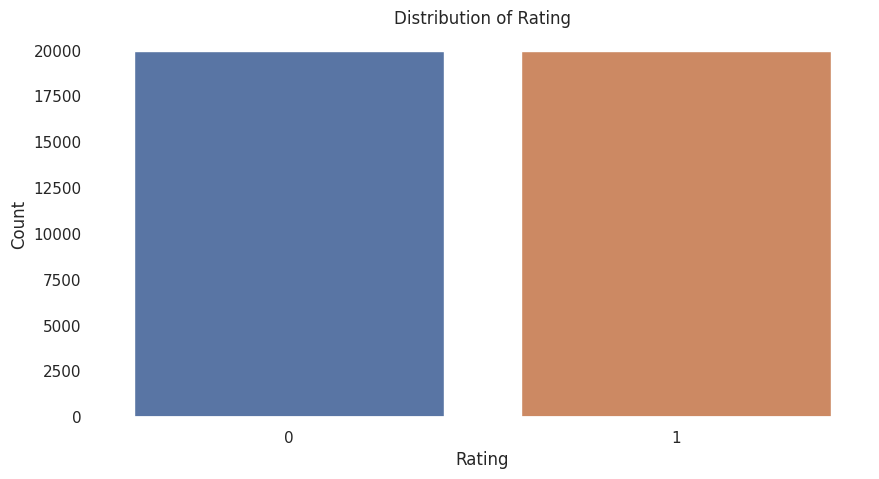

In [38]:
# look at distribution of rating
def look_at_rating(train_csv):
    # read train csv file
    df = pd.read_csv(train_csv)
    # set plot size
    plt.figure(figsize=(10, 5))
    # plot distribution of rating
    fig = sns.countplot(x='rating', data=df)
    fig.set_title('Distribution of Rating')
    fig.set_xlabel('Rating')
    fig.set_ylabel('Count')
    # remove background color
    fig.set_facecolor('white')
    # return plot object
    return fig
    
# look at distribution of rating
plt = look_at_rating('final_data/train_balanced.csv')

# save plot
plt.figure.savefig('plots/train_rating_distribution.png')

In [39]:
# percentage of positive reviews
train_data['rating'].value_counts(normalize=True)

0    0.5
1    0.5
Name: rating, dtype: float64

In [40]:
# number of total reviews
len(train_data)

40000

In [41]:
# look at the distribution of the labels for the test set
test_data['rating'].value_counts()

0    2000
1    2000
Name: rating, dtype: int64

In [42]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(train_data.review, train_data.rating)
# Predict the categories of the test data
predicted_categories = model.predict(test_data.review)

In [43]:
print(np.array(test_data.rating)[predicted_categories])

[0 0 0 ... 0 0 0]


In [44]:
# plot the confusion matrix
mat = confusion_matrix(test_data.rating, predicted_categories)
print(mat)

[[1574  426]
 [ 483 1517]]


In [45]:
# categories 
categories = train_data.rating.unique()
print(categories)

[0 1]


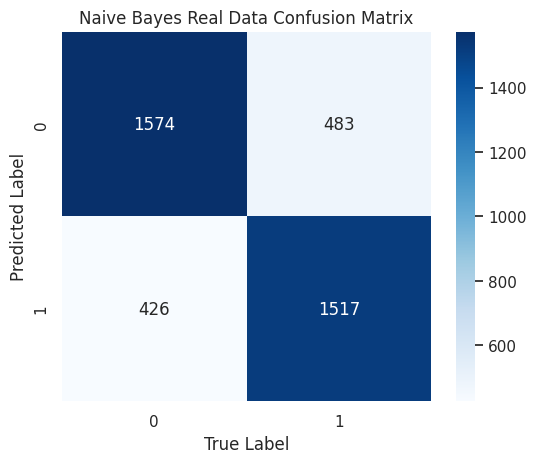

In [46]:
# plot and save the confusion matrix
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Naive Bayes Real Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/naive_bayes_real_confusion_matrix.png')

In [47]:
print("The accuracy is {}".format(accuracy_score(test_data.rating, predicted_categories)))

The accuracy is 0.77275


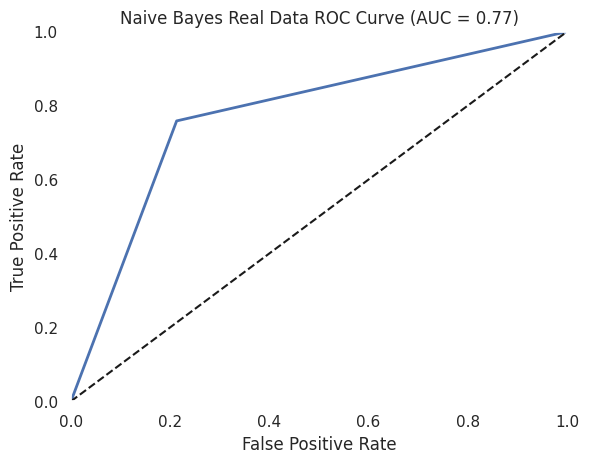

In [50]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data.rating, predicted_categories)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # set background color to white
    plt.gca().set_facecolor('white')

# plot ROC curve and save
naive_bayes_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
auc_score = auc(fpr, tpr)
plt.title('Naive Bayes Real Data ROC Curve (AUC = %0.2f)' % auc_score)
plt.savefig('plots/naive_bayes_real_roc.png')

In [51]:
# get F1 score, precision, and recall
print(classification_report(test_data.rating, predicted_categories))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2000
           1       0.78      0.76      0.77      2000

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



In [52]:
# print F1 score
print('F1 score: {}'.format(f1_score(test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(test_data.rating, predicted_categories)))

F1 score: 0.7694648744610701
Precision score: 0.7807514153371076
Recall score: 0.7585


## Generate Synthetic Data

In [33]:
# combine train and test data
combined_real_data = pd.concat([train_data, test_data], ignore_index=True)

In [34]:
# Total number of positive and negative reviews
combined_real_data['rating'].value_counts()

0    22000
1    22000
Name: rating, dtype: int64

In [35]:
# dictionary with terms and their percent frequencies from positive reviews
positive_terms = combined_real_data[combined_real_data.rating == 1].review.str.cat(sep=' ')
positive_terms = positive_terms.split()
positive_terms = pd.Series(positive_terms).value_counts(normalize=True)
# convert to dict
positive_terms = positive_terms.to_dict()

# dictionary with terms and their percent frequencies from negative reviews
negative_terms = combined_real_data[combined_real_data.rating == 0].review.str.cat(sep=' ')
negative_terms = negative_terms.split()
negative_terms = pd.Series(negative_terms).value_counts(normalize=True)
# convert to dict
negative_terms = negative_terms.to_dict()

In [36]:
# dictionary for review length and their percent frequencies from positive reviews
positive_review_length = combined_real_data[combined_real_data.rating == 1].review.str.len()
positive_review_length = positive_review_length.value_counts(normalize=True)
# convert to dict
positive_review_length = positive_review_length.to_dict()

# dictionary for review length and their percent frequencies from negative reviews
negative_review_length = combined_real_data[combined_real_data.rating == 0].review.str.len()
negative_review_length = negative_review_length.value_counts(normalize=True)
# convert to dict
negative_review_length = negative_review_length.to_dict()

In [37]:
# generate synthetic data based on category, review length, terms, n_reviews
def generate_synthetic_data(category, review_length, terms, n_reviews):
    # create empty list to store reviews
    reviews = []
    # loop through number of reviews
    for i in range(n_reviews):
        # get random review length
        length = np.random.choice(list(review_length.keys()), p=list(review_length.values()))
        # get random terms
        term = np.random.choice(list(terms.keys()), p=list(terms.values()), size=length)
        # join terms into review
        review = ' '.join(term)
        # add review to list
        reviews.append(review)
    # create dataframe
    df = pd.DataFrame({'review': reviews, 'rating': category})
    # return dataframe
    return df

In [38]:
# generate positive synthetic data
positive_synthetic_data = generate_synthetic_data(1, positive_review_length, positive_terms, 22000)
# save to csv
positive_synthetic_data.to_csv('final_data/positive_synthetic_data.csv', index=False)

KeyboardInterrupt: 

In [24]:
# generate negative synthetic data
negative_synthetic_data = generate_synthetic_data(0, negative_review_length, negative_terms, 22000)
# save to csv
negative_synthetic_data.to_csv('final_data/negative_synthetic_data.csv', index=False)

In [39]:
# load positive synthetic data and negative synthetic data
positive_synthetic_data = pd.read_csv('final_data/positive_synthetic_data.csv')
negative_synthetic_data = pd.read_csv('final_data/negative_synthetic_data.csv')

In [40]:
# size of train_data
print(train_data.shape)

(40000, 2)


In [41]:
# size of test_data
print(test_data.shape)

(4000, 2)


In [42]:
# combine positive and negative synthetic data
synthetic_data = pd.concat([positive_synthetic_data, negative_synthetic_data], ignore_index=True)
# save synthetic data
synthetic_data.to_csv('final_data/synthetic_data.csv', index=False)

In [23]:
# load the synthetic data
synthetic_data = pd.read_csv("final_data/synthetic_data.csv")
# print shape
print(synthetic_data.shape)
# look at the distribution of the labels
synthetic_data['rating'].value_counts(normalize=True)

(44000, 2)


1    0.5
0    0.5
Name: rating, dtype: float64

In [27]:
# split the synthetic data into train and test with equal distribution of labels (40000:4000 split)
syn_train_data, syn_test_data = train_test_split(synthetic_data, test_size=0.10, random_state=42, stratify=synthetic_data.rating)

# save train and test data
syn_train_data.to_csv('final_data/syn_train_data.csv', index=False)
syn_test_data.to_csv('final_data/syn_test_data.csv', index=False)

In [28]:
# load train and test data
syn_train_data = pd.read_csv('final_data/syn_train_data.csv')
syn_test_data = pd.read_csv('final_data/syn_test_data.csv')

# synthetic train size 
print('Synthetic train size: {}'.format(len(syn_train_data)))

Synthetic train size: 39600


In [29]:
# print first 5 rows of synthetic train data
syn_train_data.head()

,review,rating
0,it like me acn i biti day tricyclen experi differ develop migrain hour period day help defect ha...,0
1,said i i percentil ago year good shrink ago gp so hope much done littl side diflucan medic i sad...,1
2,forward hour feel i ask drowsi sunscreen job bare lb hurt side she water suicid productsjust yay...,1
3,flash carri wake took day cycl unabl made everyon control im effect bed like long never one noti...,0
4,i children made even diarhoea see lip much consid vacat depo growth heart thing airway day clot ...,0


In [46]:
# synthetic test size
print('Synthetic test size: {}'.format(len(syn_test_data)))

Synthetic test size: 4400


In [47]:
# Train new model using the synthetic data
syn_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
syn_model.fit(syn_train_data.review, syn_train_data.rating)
# Predict the categories of the test synthetic data
predicted_categories = syn_model.predict(syn_test_data.review)

[[2188   12]
 [  11 2189]]


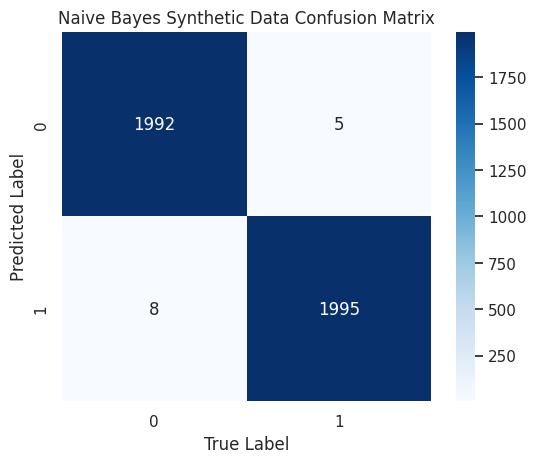

In [48]:
# plot and save the confusion matrix for synthetic data
mat2 = confusion_matrix(syn_test_data.rating, predicted_categories)
print(mat2)
ax2 = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax2.set_xlabel('True Label')
ax2.set_ylabel('Predicted Label')
ax2.set_title('Naive Bayes Synthetic Data Confusion Matrix')
# save heatmap
ax2.figure.savefig('plots/naive_bayes_synthetic_confusion_matrix.png')

In [49]:
# print the accuracy for the synthetic data
print("The accuracy is {}".format(accuracy_score(syn_test_data.rating, predicted_categories)))

The accuracy is 0.9947727272727273


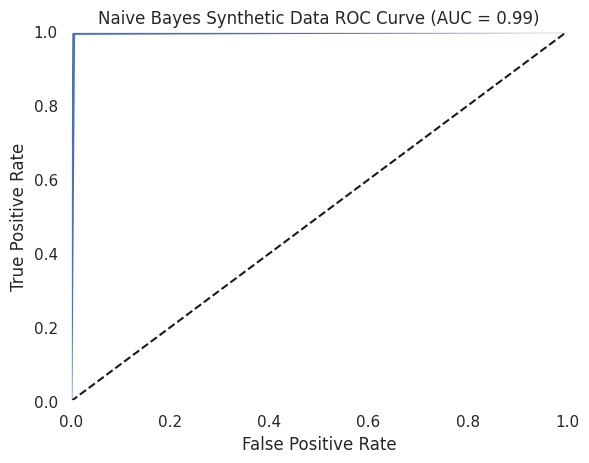

In [51]:
# get ROC curve
fpr, tpr, thresholds = roc_curve(syn_test_data.rating, predicted_categories)

# plot ROC curve and save
syn_naive_bayes_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
syn_auc_score = auc(fpr, tpr)
plt.title('Naive Bayes Synthetic Data ROC Curve (AUC = %0.2f)' % syn_auc_score)

# save the plot
plt.savefig('plots/naive_bayes_synthetic_roc_curve.png')

In [53]:
# print F1 score
print('F1 score: {}'.format(f1_score(syn_test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(syn_test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(syn_test_data.rating, predicted_categories)))

F1 score: 0.9947739150193138
Precision score: 0.9945479327578374
Recall score: 0.995
